In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

# http://www.gregreda.com/2015/08/23/cohort-analysis-with-python/

In [2]:
ORDERS_DATASET_PATH = 'orders_20190822.csv'

In [3]:
df = pd.read_csv(ORDERS_DATASET_PATH, sep=";", engine='python')

In [4]:
df.dtypes

id_o        int64
user_id     int64
price      object
o_date     object
dtype: object

In [5]:
df['price'] = df['price'].str.replace(',','.')

In [6]:
df['price'] = df['price'].astype(float)

In [7]:
df['o_date'] = df['o_date'].astype('datetime64[ns]')

In [8]:
df.head()

,id_o,user_id,price,o_date
0,1234491,337544,539.0,2016-01-01
1,1234494,171642,153.3,2016-01-01
2,1234497,260596,55.3,2016-01-01
3,1234498,1105609,752.5,2016-01-01
4,1234500,982696,4410.0,2016-01-01


In [9]:
df['order_period'] = df['o_date'].apply(lambda x: x.strftime('%Y-%m')).astype('datetime64[ns]')
df.head()

,id_o,user_id,price,o_date,order_period
0,1234491,337544,539.0,2016-01-01,2016-01-01
1,1234494,171642,153.3,2016-01-01,2016-01-01
2,1234497,260596,55.3,2016-01-01,2016-01-01
3,1234498,1105609,752.5,2016-01-01,2016-01-01
4,1234500,982696,4410.0,2016-01-01,2016-01-01


In [10]:
df.set_index('user_id', inplace=True)

df['cohort_group'] = df.groupby(level=0)['order_period'].min().apply(lambda x: x.strftime('%Y-%m'))
df.reset_index(inplace=True)
df.head()

,user_id,id_o,price,o_date,order_period,cohort_group
0,337544,1234491,539.0,2016-01-01,2016-01-01,2016-01
1,171642,1234494,153.3,2016-01-01,2016-01-01,2016-01
2,260596,1234497,55.3,2016-01-01,2016-01-01,2016-01
3,1105609,1234498,752.5,2016-01-01,2016-01-01,2016-01
4,982696,1234500,4410.0,2016-01-01,2016-01-01,2016-01


In [11]:
grouped = df.groupby(['cohort_group', 'order_period'])

In [12]:
grouped.head()

,user_id,id_o,price,o_date,order_period,cohort_group
0,337544,1234491,539.0,2016-01-01,2016-01-01,2016-01
1,171642,1234494,153.3,2016-01-01,2016-01-01,2016-01
2,260596,1234497,55.3,2016-01-01,2016-01-01,2016-01
3,1105609,1234498,752.5,2016-01-01,2016-01-01,2016-01
4,982696,1234500,4410.0,2016-01-01,2016-01-01,2016-01
...,...,...,...,...,...,...
882397,2895861,3596115,1550.5,2017-12-01,2017-12-01,2017-07
882794,2897102,3597404,4542.3,2017-12-01,2017-12-01,2017-09
882823,2874238,3597478,1785.0,2017-12-01,2017-12-01,2017-09
882876,2875820,3597645,1734.6,2017-12-01,2017-12-01,2017-09


In [13]:
cohorts = grouped.agg({'user_id': pd.Series.nunique,
                       'id_o': pd.Series.nunique,
                       'price': np.sum})

In [14]:
cohorts['price'] = cohorts['price'].astype('int')

In [15]:
cohorts.rename(columns={'user_id': 'total_users',
                        'id_o': 'total_orders',
                       'price': 'total_rubs'}, inplace=True)

In [16]:
cohorts.head()

total_users  total_orders  total_rubs
cohort_group order_period                                       
2016-01      2016-01-01          41624         53246   112520331
             2016-02-01           6042         11663    23992289
             2016-03-01           6954         14551    26709013
             2016-04-01           6953         14925    27605883
             2016-05-01           6543         14558    26926095

In [17]:
def cohort_period(df):
    """
    Creates a `cohort_period` column, which is the Nth 
    period based on the user's first purchase.
    
    Example
    -------
    Say you want to get the 3rd month for every user:
        df.sort(['user_id', 'order_time', inplace=True)
        df = df.groupby('user_id').apply(cohort_period)
        df[df.cohort_period == 3]
    """
    df['cohort_period'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

total_users  total_orders  total_rubs  \
cohort_group order_period                                          
2016-01      2016-01-01          41624         53246   112520331   
             2016-02-01           6042         11663    23992289   
             2016-03-01           6954         14551    26709013   
             2016-04-01           6953         14925    27605883   
             2016-05-01           6543         14558    26926095   

                           cohort_period  
cohort_group order_period                 
2016-01      2016-01-01                1  
             2016-02-01                2  
             2016-03-01                3  
             2016-04-01                4  
             2016-05-01                5

In [18]:
cohorts.reset_index(inplace=True)
cohorts.set_index(['cohort_group', 'cohort_period'], inplace=True)

In [19]:
cohort_group_size = cohorts['total_users'].groupby(level=0).first()
cohort_group_size.head()

cohort_group
2016-01    41624
2016-02    31406
2016-03    37177
2016-04    34187
2016-05    30950
Name: total_users, dtype: int64

In [20]:
cohorts['total_users'].head()

cohort_group  cohort_period
2016-01       1                41624
              2                 6042
              3                 6954
              4                 6953
              5                 6543
Name: total_users, dtype: int64

In [21]:
cohorts['total_users'].unstack(0).head()

cohort_group,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,...,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
cohort_period,,,,,,,,,,,,,,,,,,,,,
1,41624.0,31406.0,37177.0,34187.0,30950.0,28374.0,28408.0,31353.0,32602.0,39732.0,...,42607.0,39903.0,46173.0,41416.0,42249.0,43326.0,41385.0,49078.0,61608.0,79598.0
2,6042.0,3645.0,3845.0,2855.0,2151.0,1720.0,1685.0,1637.0,1667.0,1850.0,...,2204.0,2068.0,1926.0,1635.0,1469.0,1379.0,1547.0,1912.0,2189.0,NaN
3,6954.0,3506.0,3411.0,2401.0,1851.0,1750.0,1480.0,1702.0,1755.0,1701.0,...,2244.0,1702.0,1730.0,1488.0,1301.0,1352.0,1495.0,1682.0,NaN,NaN
4,6953.0,3406.0,3188.0,2351.0,1908.0,1703.0,1557.0,1763.0,1601.0,1241.0,...,2035.0,1702.0,1687.0,1372.0,1462.0,1554.0,1427.0,NaN,NaN,NaN
5,6543.0,3135.0,2910.0,2457.0,1956.0,1799.0,1598.0,1714.0,1118.0,979.0,...,1994.0,1610.0,1561.0,1503.0,1719.0,1502.0,NaN,NaN,NaN,NaN


In [22]:
user_retention = cohorts['total_users'].unstack(0).divide(cohort_group_size, axis=1)
user_retention

cohort_group,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,...,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
cohort_period,,,,,,,,,,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2,0.145157,0.116061,0.103424,0.083511,0.069499,0.060619,0.059314,0.052212,0.051132,0.046562,...,0.051729,0.051826,0.041713,0.039477,0.034770,0.031828,0.037381,0.038958,0.035531,NaN
3,0.167067,0.111635,0.091750,0.070231,0.059806,0.061676,0.052098,0.054285,0.053831,0.042812,...,0.052667,0.042653,0.037468,0.035928,0.030794,0.031205,0.036124,0.034272,NaN,NaN
4,0.167043,0.108451,0.085752,0.068769,0.061648,0.060020,0.054809,0.056231,0.049107,0.031234,...,0.047762,0.042653,0.036537,0.033127,0.034604,0.035868,0.034481,NaN,NaN,NaN
5,0.157193,0.099822,0.078274,0.071869,0.063199,0.063403,0.056252,0.054668,0.034292,0.024640,...,0.046800,0.040348,0.033808,0.036290,0.040687,0.034667,NaN,NaN,NaN,NaN
6,0.148472,0.098548,0.085537,0.074092,0.066397,0.066046,0.056111,0.038976,0.027084,0.029095,...,0.044007,0.039020,0.038767,0.041433,0.038084,NaN,NaN,NaN,NaN,NaN
7,0.140640,0.103069,0.090190,0.079299,0.070372,0.064954,0.040482,0.032692,0.032145,0.027434,...,0.043702,0.044257,0.044701,0.040347,NaN,NaN,NaN,NaN,NaN,NaN
8,0.149193,0.107623,0.094037,0.084945,0.070404,0.044407,0.032315,0.034861,0.029293,0.027333,...,0.048771,0.050372,0.043229,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.154598,0.113864,0.100950,0.084711,0.047658,0.035138,0.038158,0.032947,0.032023,0.024942,...,0.056728,0.046688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


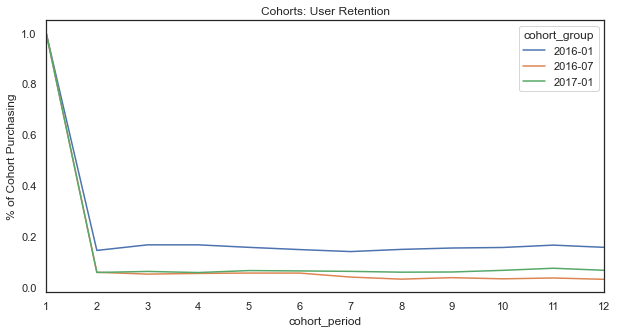

In [25]:
user_retention[['2016-01', '2016-07', '2017-01']].plot(figsize=(10,5))
plt.title('Cohorts: User Retention')
plt.xticks(np.arange(1, 12.1, 1))
plt.xlim(1, 12)
plt.ylabel('% of Cohort Purchasing');

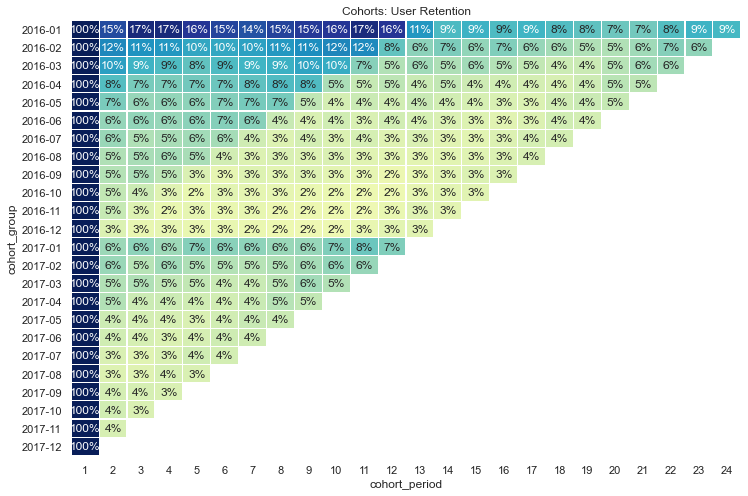

In [55]:
import seaborn as sns
sns.set(style='white')

plt.figure(figsize=(12, 8))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, vmin=0, vmax=0.18, 
            mask=user_retention.T.isnull(), linewidths=0.1, 
            annot=True, fmt='.0%', cmap="YlGnBu", cbar=False)

#### Прогноз товарооборот января 2018 года

In [59]:
user_retention['2016-01']

cohort_period
1     1.000000
2     0.145157
3     0.167067
4     0.167043
5     0.157193
6     0.148472
7     0.140640
8     0.149193
9     0.154598
10    0.156688
11    0.165962
12    0.157241
13    0.108351
14    0.085936
15    0.092663
16    0.085095
17    0.090501
18    0.083726
19    0.079089
20    0.074476
21    0.071786
22    0.083389
23    0.091678
24    0.088435
Name: 2016-01, dtype: float64

In [57]:
user_retention['2017-01']

cohort_period
1     1.000000
2     0.058537
3     0.062602
4     0.058245
5     0.065994
6     0.064579
7     0.062872
8     0.059682
9     0.060424
10    0.066893
11    0.075159
12    0.067072
13         NaN
14         NaN
15         NaN
16         NaN
17         NaN
18         NaN
19         NaN
20         NaN
21         NaN
22         NaN
23         NaN
24         NaN
Name: 2017-01, dtype: float64

In [63]:
cohorts['total_users'].unstack(0)

cohort_group,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,...,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
cohort_period,,,,,,,,,,,,,,,,,,,,,
1,41624.0,31406.0,37177.0,34187.0,30950.0,28374.0,28408.0,31353.0,32602.0,39732.0,...,42607.0,39903.0,46173.0,41416.0,42249.0,43326.0,41385.0,49078.0,61608.0,79598.0
2,6042.0,3645.0,3845.0,2855.0,2151.0,1720.0,1685.0,1637.0,1667.0,1850.0,...,2204.0,2068.0,1926.0,1635.0,1469.0,1379.0,1547.0,1912.0,2189.0,NaN
3,6954.0,3506.0,3411.0,2401.0,1851.0,1750.0,1480.0,1702.0,1755.0,1701.0,...,2244.0,1702.0,1730.0,1488.0,1301.0,1352.0,1495.0,1682.0,NaN,NaN
4,6953.0,3406.0,3188.0,2351.0,1908.0,1703.0,1557.0,1763.0,1601.0,1241.0,...,2035.0,1702.0,1687.0,1372.0,1462.0,1554.0,1427.0,NaN,NaN,NaN
5,6543.0,3135.0,2910.0,2457.0,1956.0,1799.0,1598.0,1714.0,1118.0,979.0,...,1994.0,1610.0,1561.0,1503.0,1719.0,1502.0,NaN,NaN,NaN,NaN
6,6180.0,3095.0,3180.0,2533.0,2055.0,1874.0,1594.0,1222.0,883.0,1156.0,...,1875.0,1557.0,1790.0,1716.0,1609.0,NaN,NaN,NaN,NaN,NaN
7,5854.0,3237.0,3353.0,2711.0,2178.0,1843.0,1150.0,1025.0,1048.0,1090.0,...,1862.0,1766.0,2064.0,1671.0,NaN,NaN,NaN,NaN,NaN,NaN
8,6210.0,3380.0,3496.0,2904.0,2179.0,1260.0,918.0,1093.0,955.0,1086.0,...,2078.0,2010.0,1996.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,6435.0,3576.0,3753.0,2896.0,1475.0,997.0,1084.0,1033.0,1044.0,991.0,...,2417.0,1863.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
cohorts['total_users'].unstack(0).to_csv('cohorts.csv', index=False)

In [65]:
user_retention.to_csv('user_retention.csv', index=False)